In [46]:
# exploring options to optimise particle filter params
# by optimising for accuracy over realworld log

# log was taken using nav-stack to drive around the office, and intermittently logging ground truth poses manually
# throughout the run

In [47]:
from typing import List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections as mc
from cbl_particle_filter.filter import load_input_log
from cbl_particle_filter.carpet_map import load_map_from_png
from cbl_particle_filter.filter import Pose, CarpetBasedParticleFilter, offline_playback
from cbl_particle_filter.visualisation import plot_map

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [48]:
log_dir = "/home/tfanselo/projects/personal/20210106_cbl/logs/20210419_pf_office_test/"
log_file = f"{log_dir}/localiser_input_log.pickle"
map_png = f"{log_dir}/office_map.png"

In [49]:
carpet = load_map_from_png(map_png, cell_size=0.5)

In [50]:
log = load_input_log(log_file)
# log has an incorrect waypoint - remove it
del log[954]
start_pose = log[1][2]
print(start_pose)
log

Pose(x=6.284030914306641, y=3.7079038619995117, heading=1.5411100387573244)


[(OdomMeasurement(dx=0, dy=0, dheading=0),
  Color(index=2, name='BEIGE', rgb=(241, 230, 218)),
  None),
 (None,
  None,
  Pose(x=6.284030914306641, y=3.7079038619995117, heading=1.5411100387573244)),
 (OdomMeasurement(dx=0, dy=0, dheading=0),
  Color(index=2, name='BEIGE', rgb=(241, 230, 218)),
  None),
 (OdomMeasurement(dx=0.05604982003569603, dy=0.004085414111614227, dheading=0.13431526720523834),
  Color(index=2, name='BEIGE', rgb=(241, 230, 218)),
  None),
 (OdomMeasurement(dx=0.20082752920251518, dy=0.014351533442568065, dheading=0.08323760330677032),
  Color(index=2, name='BEIGE', rgb=(241, 230, 218)),
  None),
 (OdomMeasurement(dx=0.2192966209460364, dy=-0.005794458995090332, dheading=-0.03594347834587097),
  Color(index=3, name='DARK_BLUE', rgb=(0, 51, 204)),
  None),
 (OdomMeasurement(dx=0.21387304925752554, dy=0.007336181032302241, dheading=0.07756224274635315),
  Color(index=3, name='DARK_BLUE', rgb=(0, 51, 204)),
  None),
 (OdomMeasurement(dx=0.18437462729874132, dy=0.0091

In [51]:
last_i = 0
for i, record in enumerate(log):
    if record[0] is None:
        print(f"{i}, diff\t{i-last_i}\t{record[2]}")
        last_i = i
        

1, diff	1	Pose(x=6.284030914306641, y=3.7079038619995117, heading=1.5411100387573244)
67, diff	66	Pose(x=5.7996954917907715, y=8.315444946289062, heading=0.02724654041230679)
288, diff	221	Pose(x=17.186748504638672, y=13.095357894897461, heading=-0.04752772301435471)
425, diff	137	Pose(x=32.10287094116211, y=9.768744468688965, heading=0.0138655211776495)
526, diff	101	Pose(x=42.7557258605957, y=14.798812866210938, heading=-1.5990477800369263)
631, diff	105	Pose(x=33.679683685302734, y=10.317377090454102, heading=-1.5663625001907349)
723, diff	92	Pose(x=28.171749114990234, y=18.244657516479492, heading=-1.562976598739624)
855, diff	132	Pose(x=18.558269500732422, y=12.789535522460938, heading=-2.9763805866241455)
952, diff	97	Pose(x=27.298583984375, y=12.257646560668945, heading=3.1012091636657715)
955, diff	3	Pose(x=27.165443420410156, y=12.258312225341797, heading=-3.1314425468444824)
1009, diff	54	Pose(x=18.758813858032227, y=12.775161743164062, heading=-3.129345655441284)
1089, diff	

In [57]:
def perform_playback(
    log,
    carpet_map,
    seed_pose,
    pf_params=dict(),
    ):
    """
    Localise over given log, returning a dataframe of localised poses and
    ground truth
    """
    
    np.random.seed(123)
    
    localised_poses = offline_playback(
        input_data = log,
        carpet = carpet,
        seed_pose = seed_pose,
        use_seed_messages=False,
        **pf_params,
    )    
    
    # convert results to dataframe
    ground_truth_poses = [gt_pose for _, _, gt_pose in log]

    df_data = []
    for ground_truth_pose, localised_pose in zip(ground_truth_poses, localised_poses):
        if ground_truth_pose:
            gt_x = ground_truth_pose.x
            gt_y = ground_truth_pose.y
        else:
            gt_x = float("nan")
            gt_y = float("nan")
            
        df_data.append({
            "gt_x":gt_x,
            "gt_y":gt_y,
            "loc_x":localised_pose.x,
            "loc_y":localised_pose.y,
        })
    return pd.DataFrame(df_data)

def plot_results(results_df:pd.DataFrame):    
    fig, ax = plt.subplots()
    plot_map(carpet, show=False)
    plt.plot(results_df.loc_x, results_df.loc_y, color='tab:green', marker='o',markersize=3)
    plt.plot(results_df.gt_x, results_df.gt_y, color='tab:orange', marker='o', linewidth=2)
    
    lines = [((row.loc_x, row.loc_y), (row.gt_x, row.gt_y)) for _, row in results_df.iterrows()]
    lc = mc.LineCollection(lines, colors="red")
    ax.add_collection(lc)

    plt.axis('off')
    plt.legend(['ground truth', 'particle filter output'])
    plt.show()
    
def get_playback_error(
    log,
    carpet_map,
    seed_pose,
    plot=False,
    print_inidividual_errors=False,
    pf_params=dict()
    ):
    """
    Report sum squared position error for playback of the given log
    """
    results_df = perform_playback(
        log,
        carpet_map,
        seed_pose,
        pf_params=pf_params,
    )
    ground_truth_results = results_df[~np.isnan(results_df.gt_x)].copy()
    ground_truth_results.loc[:,"position_error"] = np.linalg.norm(
        np.vstack(
            [
                ground_truth_results.loc_x - ground_truth_results.gt_x,
                ground_truth_results.loc_y - ground_truth_results.gt_y
            ]
        ),axis=0
    )
    if print_inidividual_errors:
        print(ground_truth_results)
        
    sum_squared_error = sum(np.power(ground_truth_results["position_error"],2))
    
    if plot:
        plot_results(results_df)

    return sum_squared_error

           gt_x       gt_y      loc_x      loc_y  position_error
1      6.284031   3.707904   6.314734   3.676972        0.043583
67     5.799695   8.315445   5.404047   8.350149        0.397168
288   17.186749  13.095358  17.154861  12.928364        0.170011
425   32.102871   9.768744  32.280952   9.641905        0.218635
526   42.755726  14.798813  42.459898  15.118358        0.435458
631   33.679684  10.317377  49.809180  11.567198       16.177846
723   28.171749  18.244658  40.486235  17.402684       12.343236
855   18.558270  12.789536  34.005879   9.353136       15.825216
952   27.298584  12.257647  40.634139  14.654812       13.549296
955   27.165443  12.258312  40.630164  14.657952       13.676878
1009  18.758814  12.775162  34.836343   8.174337       16.722875
1089  11.671655  14.418611  27.684742   8.608263       17.034645
1215  22.336094  12.789914  38.203516  10.185284       16.079775
1370  11.669580  10.797442  28.910857   6.386573       17.796555
1478   5.088416   5.52519

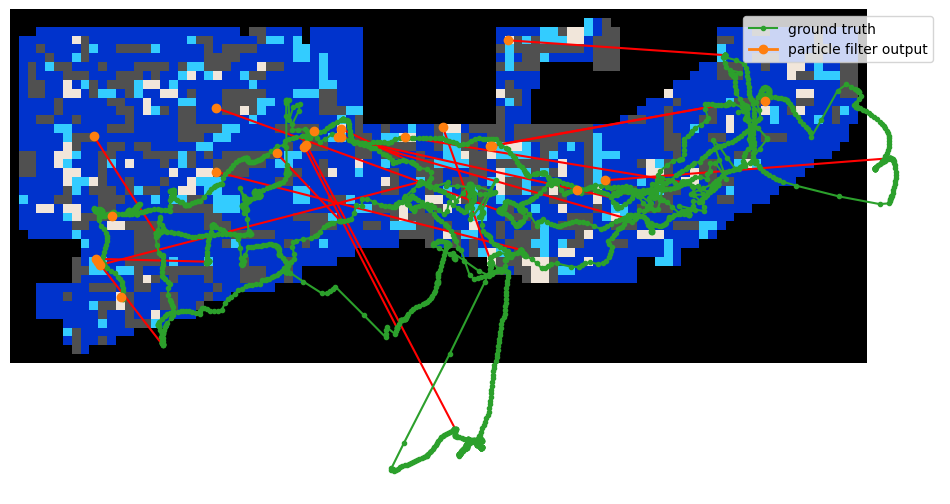

3228.226617869755

In [58]:
get_playback_error(
    log,
    carpet,
    seed_pose=start_pose,
    plot=True,
    print_inidividual_errors=True,
    pf_params=dict(
        resample_proportion=0,
        weight_fn_p=0.9,
        odom_pos_noise=0.05,
        odom_heading_noise=0.05,
        n_particles=500,
    ),
)

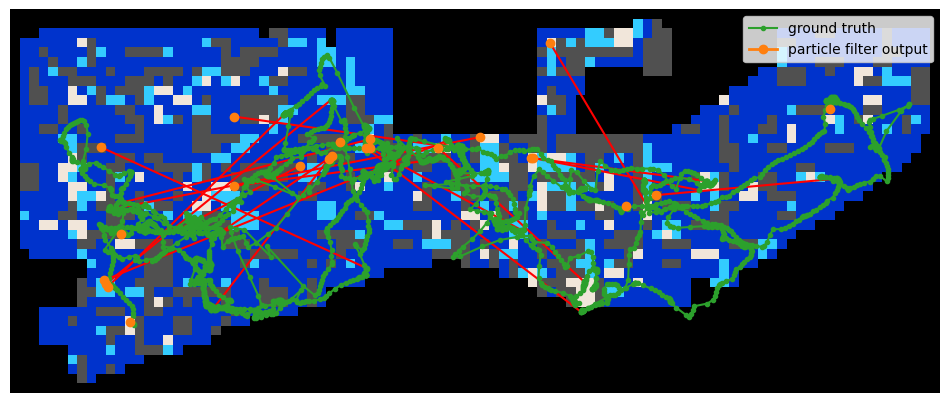

2746.289987796702

In [59]:
get_playback_error(
    log,
    carpet,
    seed_pose=start_pose,
    plot=True,
    pf_params=dict(
        resample_proportion=0,
        weight_fn_p=0.9,
        odom_pos_noise=0.1,
        odom_heading_noise=0.05,
        n_particles=500,
    )
)

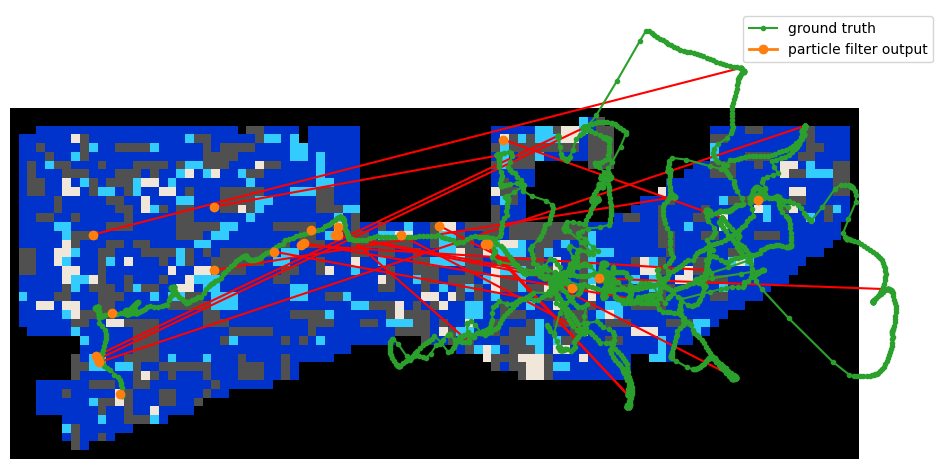

8762.860417206628

In [55]:
get_playback_error(
    log,
    carpet,
    seed_pose=start_pose,
    plot=True,
    pf_params=dict(
        resample_proportion=0,
        weight_fn_p=0.9,
        odom_pos_noise=0.01,
        odom_heading_noise=0.05,
        n_particles=500,
    ),
)

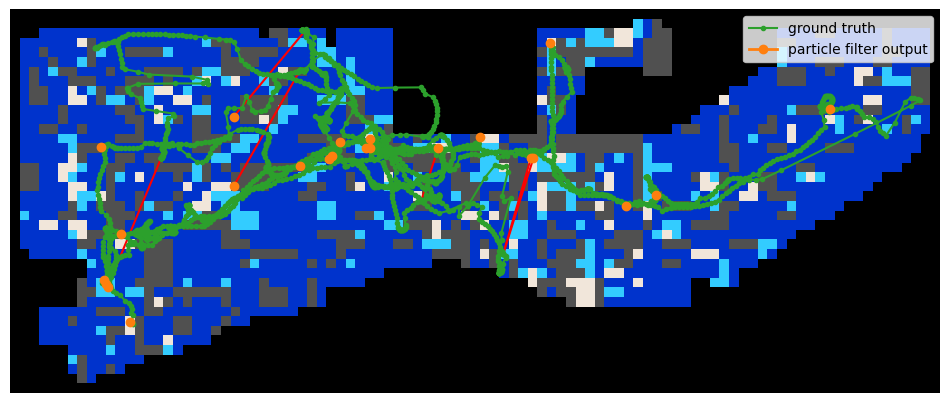

200.16145236079367

In [56]:
get_playback_error(
    log,
    carpet,
    seed_pose=start_pose,
    plot=True,
    pf_params=dict(
        resample_proportion=0,
        weight_fn_p=0.9,
        odom_pos_noise=0.0,
        odom_heading_noise=0.05,
        n_particles=500,
    )
)

In [ ]:
# Try some parameter value sweeps to look for minima

In [63]:
a  = {"a":123}
a.update({"b":234, "c":345})
a

{'a': 123, 'b': 234, 'c': 345}

In [75]:
def test_parameter_range(parameter_name:str, parameter_values:List, default_params:dict=dict()):
    
    for parameter_value in parameter_values:
        pf_params = default_params
        pf_params.update({parameter_name:parameter_value})
        error = get_playback_error(
            log,
            carpet,
            seed_pose=start_pose,
            plot=False,
            pf_params=pf_params,        
        )
        print(f"{parameter_name}={parameter_value},\t{error=}")
                         
default_params = dict(
    resample_proportion=0,
    weight_fn_p=0.9,
    odom_pos_noise=0.0,
    odom_heading_noise=0.05,
    n_particles=500,
)

In [77]:
test_parameter_range("odom_pos_noise",[0, 0.005, 0.01, 0.02, 0.1, 1.0], default_params = dict(
    resample_proportion=0,
    weight_fn_p=0.9,
    odom_pos_noise=0.0,
    odom_heading_noise=0.05,
    n_particles=500,
))

odom_pos_noise=0,	error=200.16145236079367
odom_pos_noise=0.005,	error=17512.644228704987
odom_pos_noise=0.01,	error=8762.860417206628
odom_pos_noise=0.02,	error=5904.291555902299
odom_pos_noise=0.1,	error=2746.289987796702
odom_pos_noise=1.0,	error=3186.4595130341763


In [71]:
# looks like a minimum for odom_pos_noise around 0.01

In [78]:
test_parameter_range("odom_heading_noise",[0, 0.005, 0.01, 0.05, 0.1, 1.0], default_params)

odom_heading_noise=0,	error=13653.47129784551
odom_heading_noise=0.005,	error=12927.958625702666
odom_heading_noise=0.01,	error=11552.395506336878
odom_heading_noise=0.05,	error=200.16145236079367
odom_heading_noise=0.1,	error=6816.298209501635
odom_heading_noise=1.0,	error=4046.2078228241717


In [ ]:
# odom_heading_noise also looks good around 0.01

# Note that odometry in this case is generated by the gazebo_ros_diff_drive plugin, which does not appear to 
# add any noise to the simulated output
# https://github.com/ros-simulation/gazebo_ros_pkgs/blob/kinetic-devel/gazebo_plugins/src/gazebo_ros_diff_drive.cpp
# This could lead to significantly different results between simulation and reality.
# Relevant to adding noise to gazebo odom:
# https://blog.lxsang.me/post/id/16

In [80]:
test_parameter_range("resample_proportion",[0, 0.01, 0.1, 1.0], default_params = dict(
    resample_proportion=0,
    weight_fn_p=0.9,
    odom_pos_noise=0.0,
    odom_heading_noise=0.05,
    n_particles=500,
))

resample_proportion=0,	error=200.16145236079367
resample_proportion=0.01,	error=1882.496335637216
resample_proportion=0.1,	error=2763.744822937935
resample_proportion=1.0,	error=2682.026313105513


In [ ]:
# resample proportion doesn't appear to help at all.
# My assumption would be that this resampling increases the chance of recovering from loss of localisation,
# at the expense of degrading accuracy in the normal case.

In [86]:
test_parameter_range("weight_fn_p",[0.5, 0.8, 0.9, 0.95, 0.99, 1.0], default_params = dict(
    resample_proportion=0,
    weight_fn_p=0.9,
    odom_pos_noise=0.0,
    odom_heading_noise=0.05,
    n_particles=10000,
))

weight_fn_p=0.5,	error=9485.312925728895
weight_fn_p=0.8,	error=1.260894477701343
weight_fn_p=0.9,	error=1.3856714845963694
weight_fn_p=0.95,	error=4358.839654984464
weight_fn_p=0.99,	error=6864.469917467933


/home/tfanselo/projects/personal/20210106_cbl/carpet_localisation/venv/lib/python3.8/site-packages/pfilter/pfilter.py:347: RuntimeWarning: divide by zero encountered in log
  self.weight_entropy = np.sum(self.weights * np.log(self.weights))
/home/tfanselo/projects/personal/20210106_cbl/carpet_localisation/venv/lib/python3.8/site-packages/pfilter/pfilter.py:347: RuntimeWarning: invalid value encountered in multiply
  self.weight_entropy = np.sum(self.weights * np.log(self.weights))
/home/tfanselo/projects/personal/20210106_cbl/carpet_localisation/venv/lib/python3.8/site-packages/pfilter/pfilter.py:342: RuntimeWarning: invalid value encountered in true_divide
  self.weights = weights / self.weight_normalisation


weight_fn_p=1.0,	error=nan


In [87]:
test_parameter_range("weight_fn_p",[0.7, 0.8, 0.9], default_params = dict(
    resample_proportion=0,
    weight_fn_p=0.9,
    odom_pos_noise=0.0,
    odom_heading_noise=0.05,
    n_particles=10000,
))

weight_fn_p=0.7,	error=1.5595888695330047
weight_fn_p=0.8,	error=1.260894477701343
weight_fn_p=0.9,	error=1.3856714845963694


In [ ]:
# notice multiple local minima, at p=0.95 and p=1.0
# I'd guess these parameter sweeps are partially susceptible to 
# noise / edge cases for particular parameterisations.
# out of interest, plot the last three trajectories, to see what goes wrong when p=0.99

weight_fn_p=0.95


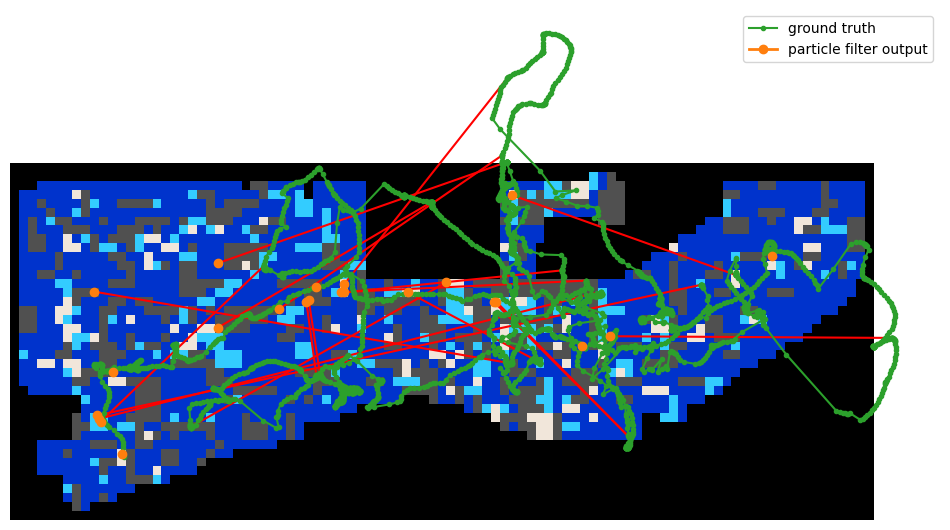

weight_fn_p=0.99


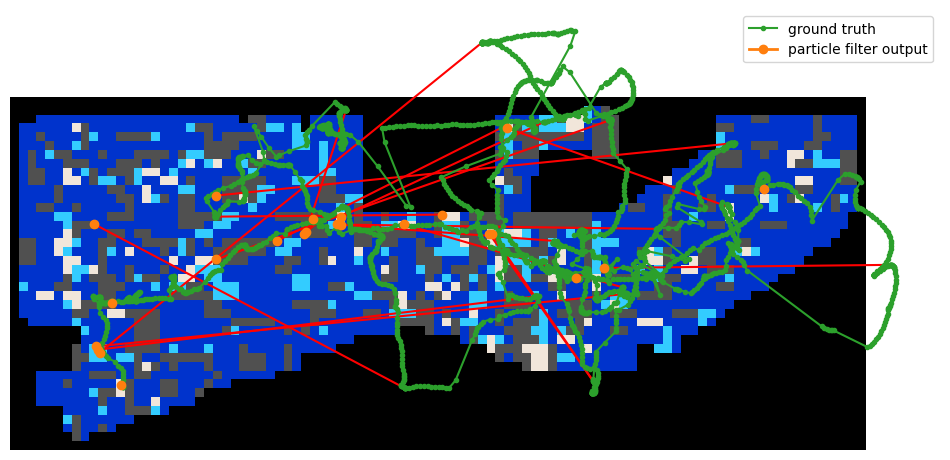

weight_fn_p=1.0


/home/tfanselo/projects/personal/20210106_cbl/carpet_localisation/venv/lib/python3.8/site-packages/pfilter/pfilter.py:347: RuntimeWarning: divide by zero encountered in log
  self.weight_entropy = np.sum(self.weights * np.log(self.weights))
/home/tfanselo/projects/personal/20210106_cbl/carpet_localisation/venv/lib/python3.8/site-packages/pfilter/pfilter.py:347: RuntimeWarning: invalid value encountered in multiply
  self.weight_entropy = np.sum(self.weights * np.log(self.weights))
/home/tfanselo/projects/personal/20210106_cbl/carpet_localisation/venv/lib/python3.8/site-packages/pfilter/pfilter.py:342: RuntimeWarning: invalid value encountered in true_divide
  self.weights = weights / self.weight_normalisation


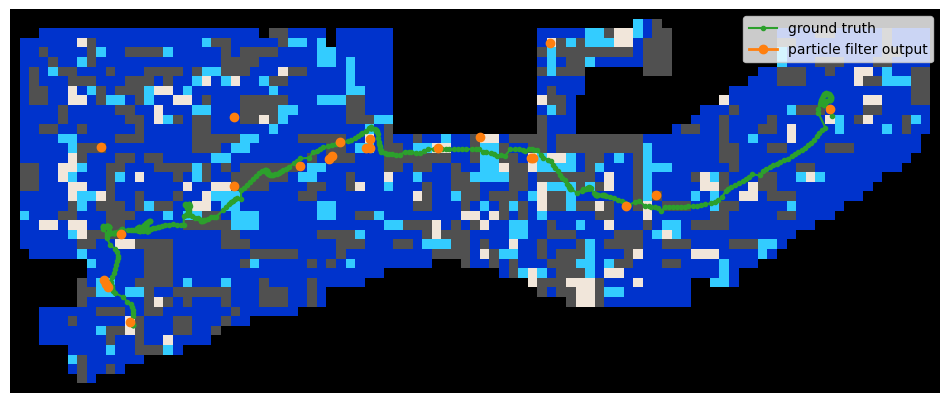

In [82]:
for weight_fn_p in [0.95, 0.99, 1.0]:
    print(f"{weight_fn_p=}")
    get_playback_error(
        log,
        carpet,
        seed_pose=start_pose,
        plot=True,
        pf_params=dict(
            weight_fn_p=weight_fn_p,
        )
    )

In [ ]:
# couldnt see any obvious differences in the trajectories.

In [84]:
test_parameter_range("n_particles",[10, 100, 1000, 10000], default_params = dict(
    resample_proportion=0,
    weight_fn_p=0.9,
    odom_pos_noise=0.0,
    odom_heading_noise=0.05,
    n_particles=500,
))

n_particles=10,	error=13339.823512969946
n_particles=100,	error=6155.1774794735775
n_particles=1000,	error=16179.102465794609
n_particles=10000,	error=1.3856714845963694


In [ ]:
# more particles = better, but also slower. 10k took quite a while to complete

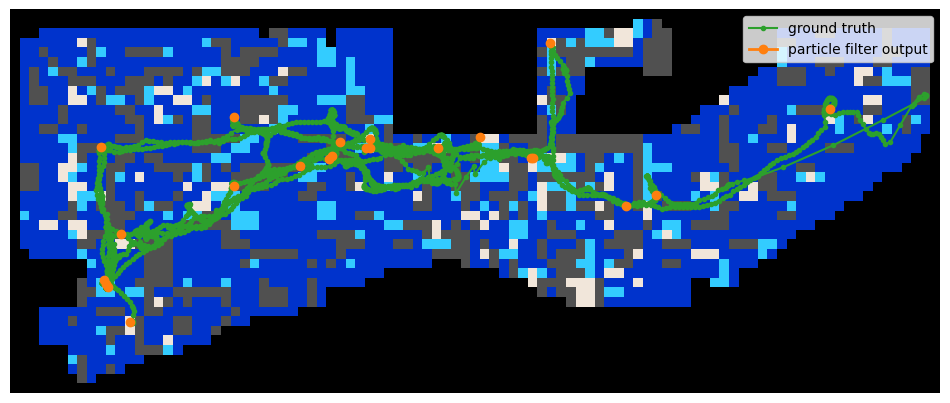

1.260894477701343

In [88]:
get_playback_error(
    log,
    carpet,
    seed_pose=start_pose,
    plot=True,
    pf_params=dict(
        resample_proportion=0,
        weight_fn_p=0.8,
        odom_pos_noise=0.0,
        odom_heading_noise=0.05,
        n_particles=10000,
    )
)

In [ ]:
# more focused particle number testing
test_parameter_range("n_particles",[100, 200, 300, 500, 700, 1000])

In [ ]:
# anything over 200 does not appear to have a large effect on error, although I'd still want to keep the number
# high for general robustness (don't want to overfit this limited dataset)

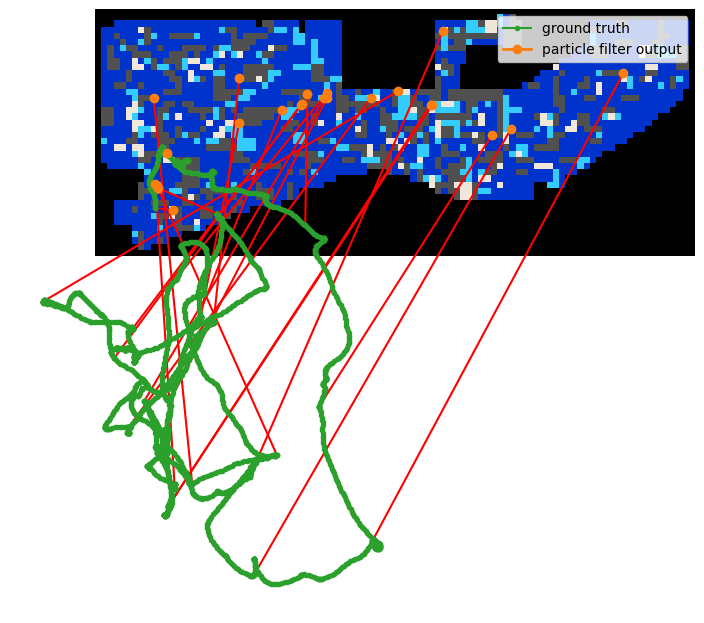

17446.31124998384

In [90]:
# Try odom only

get_playback_error(
        log,
        carpet,
        seed_pose=start_pose,
        plot=True,
        pf_params=dict(
            odom_pos_noise=0.0,
            odom_heading_noise=0.0,
            resample_proportion=0,
            weight_fn_p = 0.5,
            n_particles = 2
        )
    )

In [ ]:
# looks pretty good, except for a position jump around the start of the trajectory.
# I'm also concerned about overfitting to simulated data.
# Will test these parameters in real world and observe performance.